### Machine Learning Audio Classification MEL CRNN
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.7.0
Num GPUs Available:  1


2022-02-13 13:52:23.082263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 13:52:23.122127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 13:52:23.122395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MEL FEATURE READ IN
In this section we will read in our kaggle 2018 datasets which have already been featured extracted and normalized

In [2]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MFCC train data
X_train = np.load( os.path.join(data_npy_folder, "X-mel-train.npy" ) )
y_train = np.load( os.path.join(data_npy_folder, "y-mel-train.npy" ) )

# load in pre-processed MFCC train data
X_test = np.load( os.path.join(data_npy_folder, "X-mel-test.npy" ) )
y_test = np.load( os.path.join(data_npy_folder, "y-mel-test.npy" ) )


In [3]:
# output X_train and X_test shape
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# output y_train and y_test shape
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (9473, 128, 345), X_test shape: (1600, 128, 345)
y_train shape: (9473,), y_test shape: (1600,)


### Visualize the label count distribution for train and test data

<BarContainer object of 41 artists>

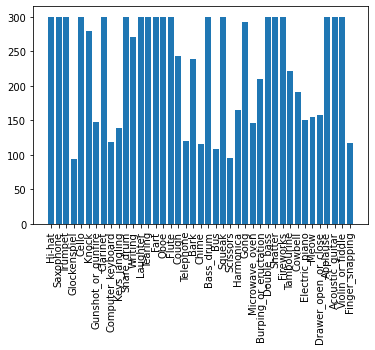

In [4]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

<BarContainer object of 41 artists>

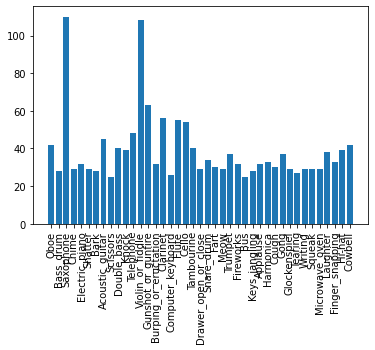

In [5]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

### Encode Labels
In this section we will encode to categorical our y data

In [6]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))

In [7]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

n_c = 0
#y_train[0], y_train_encoded[0], num_labels
y_train_encoded[n_c], le.classes_[n_c], num_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'Acoustic_guitar',
 41)

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [8]:
n_mfcc = 128 # IDK from orignal data shape I forgot to control n_fft and hop_length
sampling_rate = 44100
audio_duration = 4
audio_length = audio_duration * sampling_rate
input_shape = (n_mfcc, 1 + int(np.floor(audio_length/512)), 1)
input_shape

(128, 345, 1)

In [9]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

### Construct the model
In this section we will construct the model

In [46]:
def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = Conv2D(
        64, 3, padding='same', activation='relu', name='conv1')(x)
    x = MaxPool2D(pool_size=2, padding='same', name='pool1')(x)

    x = Conv2D(
        128, 3, padding='same', activation='relu', name='conv2')(x)
    x = MaxPool2D(pool_size=2, padding='same', name='pool2')(x)

    x = Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu', name='relu3')(x)
    x = Conv2D(
        256, 3, padding='same', activation='relu', name='conv4')(x)
    x = MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool4')(x)

    x = Conv2D(512, 3, padding='same', use_bias=False, name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu', name='relu5')(x)
    x = Conv2D(
        512, 3, padding='same', activation='relu', name='conv6')(x)
    x = MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool6')(x)

    x = Conv2D(512, 2, use_bias=False, name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu', name='relu7')(x)

    x = Reshape((-1, 512), name='reshape7')(x)
    return x

In [49]:
if resume is False: # if we are not resuming from a previous model

    img_input = Input(shape=input_shape)
    print(img_input)
    x = img_input
    x = vgg_style(x)
    x = Bidirectional(
        LSTM(units=256, return_sequences=True), name='bi_lstm1')(x)
    x = Bidirectional(
        LSTM(units=256, return_sequences=True), name='bi_lstm2')(x)
    x = Dense(units=num_labels, name='logits')(x)
    
    # if postprocess is not None:
    #     x = postprocess(x)

    model = Model(inputs=img_input, outputs=x, name="VGG_CRNN")

#     ipt = Input(shape=(sampling_rate, 1))
#     x = ipt
#     x = Conv1D(filters=64, kernel_size=50, strides=50, padding='valid', activation='relu')(x)
#     x = Conv1D(filters=64, kernel_size=50, strides=50, padding='valid', activation='relu')(x)
#     x = BatchNormalization()(x)
    
#     # LSTM
#     x = LSTM(32)(x)
    
#     # double
# #     x = LSTM(32, return_sequences=True)(x)
# #     x = LSTM(32, return_sequences=False)(x)
    
#     # 正反
# #     r   = LSTM(32, return_sequences=True, go_backwards=False)(x)
# #     r_b = LSTM(32, return_sequences=True, go_backwards=True)(x)
# #     x = concatenate([r, r_b])
# #     x = Flatten()(x)

#     x = Dropout(0.3)(x)
#     x = Dense(num_labels, activation='softmax')(x)
    
#     model = Model(inputs=[ipt], outputs=[x])


KerasTensor(type_spec=TensorSpec(shape=(None, 128, 345, 1), dtype=tf.float32, name='input_18'), name='input_18', description="created by layer 'input_18'")


### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [29]:
# 2. compile the model
if resume is False:
    learing_rate = 1e-4 #0.000001 # 5
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 500 # standard we are training for 500 epochsmodel_path
    num_batch_size = 32 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance

    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

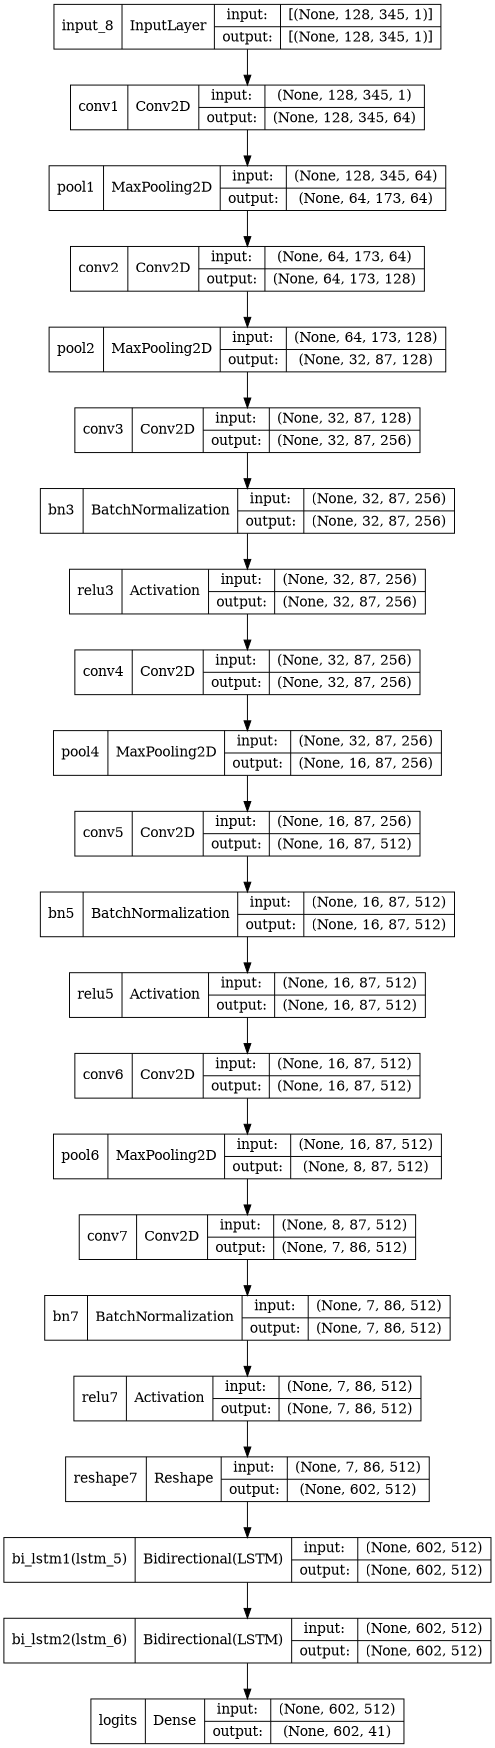

In [30]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [31]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'MEL_VGG_CRNN_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_cc_v4.h5')
else:
    num_epochs = 500
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_VGG_CRNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5'

In [32]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10#6#3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    validation_data=(X_test, y_test_encoded),
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    #validation_split=1/12.,
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

2022-02-13 14:07:46.528467: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1673310720 exceeds 10% of free system memory.


Epoch 1/500


ValueError: in user code:

    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/charlesedwards/.local/lib/python3.8/site-packages/keras/backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 41) and (None, 602, 41) are incompatible


Text(0.5, 0, 'epochs')

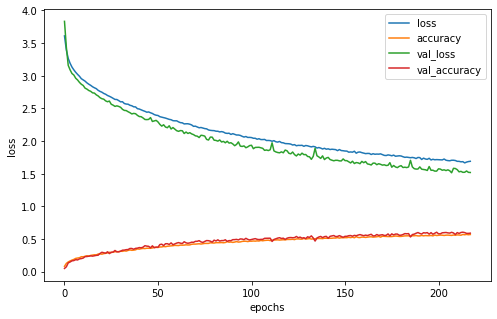

In [17]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [18]:

model.metrics_names

['loss', 'accuracy']

In [19]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v4.h5')

model = load_model(model_path)

In [20]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2022-02-13 05:43:22.008921: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1673310720 exceeds 10% of free system memory.
2022-02-13 05:43:22.797806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1673310720 exceeds 10% of free system memory.


50/50 [==============================] - 2s 29ms/step - loss: 1.5119 - accuracy: 0.6006
                    LOSS      ACCURACY
--------------------------------------
Training:         1.5008       62.0184
Test:             1.5119       60.0625
Normal diff          0.74 


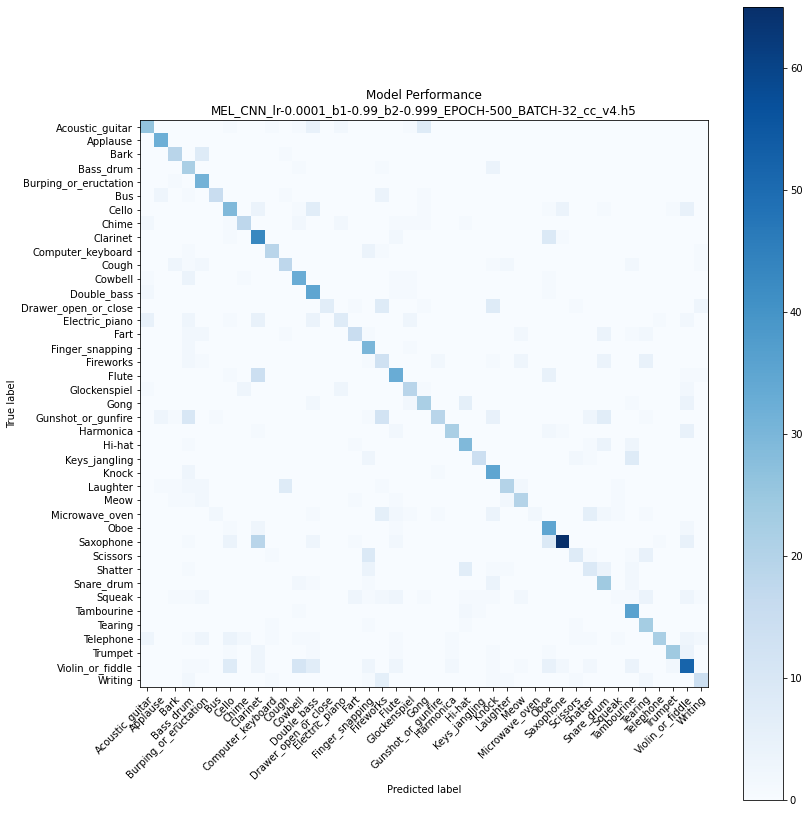

In [21]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=le.classes_.tolist(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [25]:
importlib.reload(helper)
model, metadata = helper.load_model_ext(model_path)
model, metadata

(<keras.engine.sequential.Sequential at 0x7faa3b4263d0>,
 '["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]')

In [23]:
import json
lables_properly = le.classes_.tolist()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]'

In [24]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json)